# Car Price Prediction

This notebook implements a multiple linear regression model to predict the price of a car based on its features. The dataset used is the Car Price Prediction dataset from Kaggle, that contains 25 features and 1 target lable (price) for about 200 US and European cars.

You can find the dataset here:
> https://www.kaggle.com/datasets/hellbuoy/car-price-prediction

### Imports

Some libraries will be needed to run this notebook. The libraries are:
> pandas, to read the CSV files and manipulate the data.

> torch, to create the model, train it and evaluate it.

> sklearn, to split the dataset into training and test sets and scale it.

> matplotlib, to plot the data and the model.

In [1]:
import pandas as pd

import torch
from torch import nn
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LinReg

import matplotlib.pyplot as plt
import seaborn as sns

### Data Exploration

It is important to understand the data before building a model. The first step is to read the CSV file and create a pandas dataframe with the data.

In [2]:
df = pd.read_csv('CarPrice_Assignment.csv')
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [3]:
df.sample(5)

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
131,132,2,renault 5 gtl,gas,std,two,hatchback,fwd,front,96.1,...,132,mpfi,3.46,3.90,8.7,90,5100,23,31,9895.0
45,46,0,isuzu D-Max V-Cross,gas,std,four,sedan,fwd,front,94.5,...,90,2bbl,3.03,3.11,9.6,70,5400,38,43,8916.5
91,92,1,nissan rogue,gas,std,two,sedan,fwd,front,94.5,...,97,2bbl,3.15,3.29,9.4,69,5200,31,37,6649.0
120,121,1,plymouth fury iii,gas,std,four,hatchback,fwd,front,93.7,...,90,2bbl,2.97,3.23,9.4,68,5500,31,38,6229.0
116,117,0,peugeot 504,diesel,turbo,four,sedan,rwd,front,107.9,...,152,idi,3.70,3.52,21.0,95,4150,28,33,17950.0


A correlation matrix is then created to see how the features are correlated with each other. The correlation matrix is plotted as a heatmap to improve visualization. It is valid to note that 'enginesize' and 'curbweight' are the features that are most correlated with the price of the car.

<Axes: >

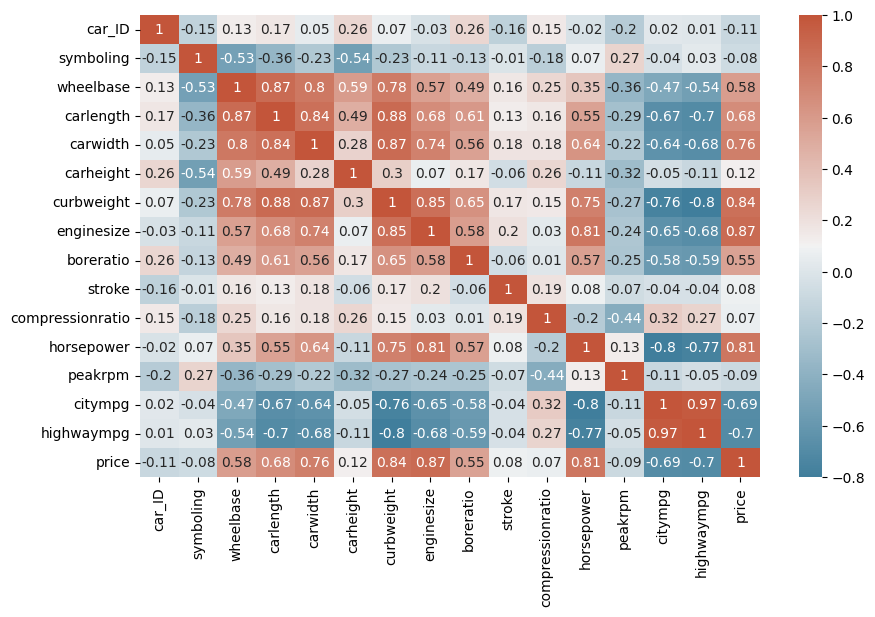

In [4]:
corr = df.corr(numeric_only=True).round(2)

fig, ax = plt.subplots(figsize=(10,6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap)

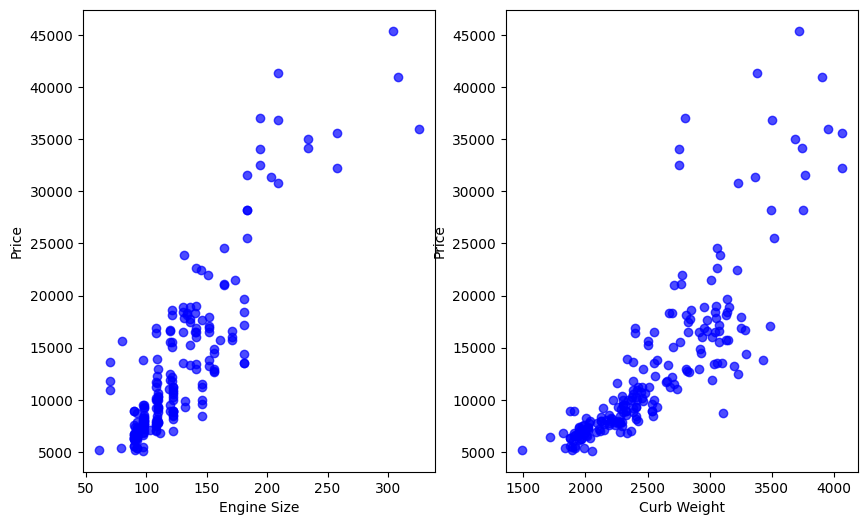

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))

ax1.scatter(df['enginesize'], df['price'], c='blue', alpha=0.7)
ax1.set_xlabel('Engine Size')
ax1.set_ylabel('Price')

ax2.scatter(df['curbweight'], df['price'], c='blue', alpha=0.7)
ax2.set_xlabel('Curb Weight')
ax2.set_ylabel('Price')

plt.show()

### Data Cleaning

It is necessary to clean and format the data before building the model. It is necessary to check for missing values. If there are any, they must be removed or replaced. We also need to check for categorical features. If there are any, they must be converted to numerical values.

In [6]:
df.isnull().sum().any()

False

Let's also remove some columns that are not relevant to the model. Features like car_ID and CarName consist basically of unique values and have no statistic value.

In [7]:
df.drop(['car_ID', 'CarName'], axis=1, inplace=True)
df

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,-1,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.8,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,-1,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,-1,diesel,turbo,four,sedan,rwd,front,109.1,188.8,68.9,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0


These are all the catehorical features we have:

In [8]:
categorycal_keys = [i for i in df.keys() if df[i].dtype == 'O']

for key in categorycal_keys:
    print(df[key].value_counts())
    print('-------------------------')

fueltype
gas       185
diesel     20
Name: count, dtype: int64
-------------------------
aspiration
std      168
turbo     37
Name: count, dtype: int64
-------------------------
doornumber
four    115
two      90
Name: count, dtype: int64
-------------------------
carbody
sedan          96
hatchback      70
wagon          25
hardtop         8
convertible     6
Name: count, dtype: int64
-------------------------
drivewheel
fwd    120
rwd     76
4wd      9
Name: count, dtype: int64
-------------------------
enginelocation
front    202
rear       3
Name: count, dtype: int64
-------------------------
enginetype
ohc      148
ohcf      15
ohcv      13
dohc      12
l         12
rotor      4
dohcv      1
Name: count, dtype: int64
-------------------------
cylindernumber
four      159
six        24
five       11
eight       5
two         4
three       1
twelve      1
Name: count, dtype: int64
-------------------------
fuelsystem
mpfi    94
2bbl    66
idi     20
1bbl    11
spdi     9
4bbl     3


The get_dummies function from pandas will convert these features to numerical values. The feature count will increase, but it will be easier to work with the data.

In [9]:
df = pd.get_dummies(df, dtype=float)
df

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,...,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
0,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,109.1,188.8,68.9,55.5,2952,141,3.78,3.15,9.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
201,-1,109.1,188.8,68.8,55.5,3049,141,3.78,3.15,8.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
202,-1,109.1,188.8,68.9,55.5,3012,173,3.58,2.87,8.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
203,-1,109.1,188.8,68.9,55.5,3217,145,3.01,3.40,23.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


These are all the collumns we have now:

In [10]:
df.columns

Index(['symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight',
       'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio',
       'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price',
       'fueltype_diesel', 'fueltype_gas', 'aspiration_std', 'aspiration_turbo',
       'doornumber_four', 'doornumber_two', 'carbody_convertible',
       'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_4wd', 'drivewheel_fwd', 'drivewheel_rwd',
       'enginelocation_front', 'enginelocation_rear', 'enginetype_dohc',
       'enginetype_dohcv', 'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf',
       'enginetype_ohcv', 'enginetype_rotor', 'cylindernumber_eight',
       'cylindernumber_five', 'cylindernumber_four', 'cylindernumber_six',
       'cylindernumber_three', 'cylindernumber_twelve', 'cylindernumber_two',
       'fuelsystem_1bbl', 'fuelsystem_2bbl', 'fuelsystem_4bbl',
       'fuelsystem_idi', 'fuelsystem_mfi', 'fuelsystem_m

Fortunately, there are no inconsistent data types:

In [11]:
df.dtypes

symboling                  int64
wheelbase                float64
carlength                float64
carwidth                 float64
carheight                float64
curbweight                 int64
enginesize                 int64
boreratio                float64
stroke                   float64
compressionratio         float64
horsepower                 int64
peakrpm                    int64
citympg                    int64
highwaympg                 int64
price                    float64
fueltype_diesel          float64
fueltype_gas             float64
aspiration_std           float64
aspiration_turbo         float64
doornumber_four          float64
doornumber_two           float64
carbody_convertible      float64
carbody_hardtop          float64
carbody_hatchback        float64
carbody_sedan            float64
carbody_wagon            float64
drivewheel_4wd           float64
drivewheel_fwd           float64
drivewheel_rwd           float64
enginelocation_front     float64
engineloca

Splitting the dataset into features and target label:

In [12]:
X = df.drop('price', axis=1)
y = df['price']

X.shape, y.shape

((205, 52), (205,))

Splitting the dataset into training and test sets:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((143, 52), (62, 52), (143,), (62,))

Model made using PyTorch only works with tensors, so we need to convert the data to tensors. We will also split the data into training and test sets. For the target labels, it was needed to unsqueeze the data to make it work with our model (its shape has to be [_, 1]).

In [14]:
X_train = torch.tensor(X_train.values).type(torch.float)
y_train = torch.tensor(y_train.values).type(torch.float).unsqueeze(dim=1)

X_test = torch.tensor(X_test.values).type(torch.float)
y_test = torch.tensor(y_test.values).type(torch.float).unsqueeze(dim=1)

X_train[:1], y_train[:2]

(tensor([[-1.0000e+00,  1.0240e+02,  1.7560e+02,  6.6500e+01,  5.3900e+01,
           2.4580e+03,  1.2200e+02,  3.3100e+00,  3.5400e+00,  8.7000e+00,
           9.2000e+01,  4.2000e+03,  2.7000e+01,  3.2000e+01,  0.0000e+00,
           1.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
           0.0000e+00,  0.0000e+00]]),
 tensor([[11248.],
         [16503.]]))

### Model

The model used is a multiple linear regression model. It is a simple model with six layers, the output layer has only one node, the predicted price and the activation function used is the ReLU function.

In [15]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(in_features=input_size, out_features=64)
        self.layer2 = nn.Linear(in_features=64, out_features=128)
        self.layer3 = nn.Linear(in_features=128, out_features=256)
        self.layer4 = nn.Linear(in_features=256, out_features=512)
        self.layer5 = nn.Linear(in_features=512, out_features=256)
        self.layer6 = nn.Linear(in_features=256, out_features=output_size)
        
    def forward(self, x):
        x = nn.ReLU()(self.layer1 (x))
        x = nn.ReLU()(self.layer2 (x))
        x = nn.ReLU()(self.layer3 (x))
        x = nn.ReLU()(self.layer4 (x))
        x = nn.ReLU()(self.layer5 (x))
        return self.layer6(x)
    
    def predict(self, x):
        x = self.forward(x)
        return x    

A manual seed is set to avoid different results between equal runs.

In [16]:
torch.manual_seed(9)

n_samples, n_features = X_train.shape[0],  X_train.shape[1]
model_0 = LinearRegression(n_features, 1)
model_0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 4.3207e-02, -5.4909e-02, -5.5757e-03,  ..., -1.2381e-01,
                        7.1385e-02,  2.2114e-02],
                      [ 6.6555e-02,  6.6907e-02, -2.0279e-02,  ...,  1.3036e-01,
                       -4.3871e-02,  1.3651e-02],
                      [-8.4702e-02,  3.0599e-02,  2.3079e-02,  ...,  1.3745e-01,
                       -6.1203e-03, -1.0926e-01],
                      ...,
                      [ 4.6503e-02,  4.9302e-02, -1.3244e-01,  ...,  1.0051e-01,
                        7.1579e-02, -4.3381e-02],
                      [-3.9026e-02, -8.1435e-05,  4.3311e-02,  ..., -2.2221e-02,
                        8.3333e-02,  1.3680e-01],
                      [-1.0967e-01, -7.8737e-03, -8.9651e-02,  ...,  1.3442e-01,
                       -7.9438e-02, -1.1045e-01]])),
             ('layer1.bias',
              tensor([-0.1157,  0.0473,  0.1018,  0.0365,  0.1294,  0.0692,  0.0294,  0.0511,
                      -0.1031,

To train the model, we need to define the loss function and the optimizer. The loss function used is the Mean Squared Error (MSE). The optimizer used is the Adaptive Moment Estimation (Adam). The learning rate is set to 0.01.

In [17]:
max_epochs = 2000

lr = 0.01
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=lr)

loss_list = []
for epoch in range(1, max_epochs+1):
    model_0.train()
    y_pred = model_0(X_train)
    
    loss = loss_fn(y_pred, y_train)
    loss_list.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_0.eval()
    with torch.inference_mode():
        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss.item()} | Test loss: {test_loss.item()}")

Epoch: 100 | Train loss: 15273998.0 | Test loss: 19090346.0
Epoch: 200 | Train loss: 9227340.0 | Test loss: 13293836.0
Epoch: 300 | Train loss: 6426723.5 | Test loss: 10859661.0
Epoch: 400 | Train loss: 5225592.5 | Test loss: 9568761.0
Epoch: 500 | Train loss: 4363448.5 | Test loss: 8330813.5
Epoch: 600 | Train loss: 2899795.25 | Test loss: 7117965.5
Epoch: 700 | Train loss: 2036513.125 | Test loss: 5840077.5
Epoch: 800 | Train loss: 2585003.0 | Test loss: 6591529.5
Epoch: 900 | Train loss: 2618955.5 | Test loss: 7042143.0
Epoch: 1000 | Train loss: 1439665.625 | Test loss: 5365381.5
Epoch: 1100 | Train loss: 4230084.5 | Test loss: 5874001.0
Epoch: 1200 | Train loss: 1630178.625 | Test loss: 5451828.5
Epoch: 1300 | Train loss: 1701679.625 | Test loss: 4841045.0
Epoch: 1400 | Train loss: 1317308.625 | Test loss: 4632579.5
Epoch: 1500 | Train loss: 4809956.0 | Test loss: 6392190.5
Epoch: 1600 | Train loss: 1165677.375 | Test loss: 5071047.0
Epoch: 1700 | Train loss: 1489284.25 | Test loss

Here is a graph showing the loss function value for each epoch, note that the loss function decreases as the number of epochs increases. Analyzing the graph, it is possible to see that the loss function decreases faster in the first epochs and then it decreases slower, perhaps it would not make much difference to use a smaller number of epochs.

Even though the losses seem to still be high, it is important to check different metrics to evaluate the model.

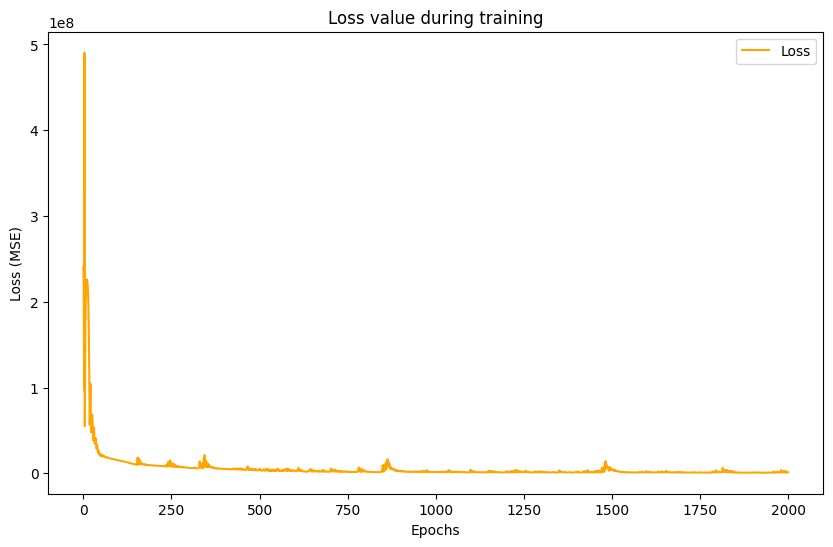

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range(max_epochs), loss_list, c='orange', label='Loss')
ax.set_title("Loss value during training")
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss (MSE)')

ax.legend()
plt.show()

Looking at the R2 score, we can see that the model has a good performance. The R2 score is a metric that measures how close the data is to the fitted regression line. The closer to 1, the better the model. The losses were probably high because magnitude of the target labels is high.

In [19]:
test_pred = model_0(X_test)

metric = R2Score()
metric.update(test_pred, y_test)
metric.compute()

tensor(0.9249)

Let's compare it with a pre made model from sklearn. The method score() also returns the R2 score. The model from sklearn had a worst performance, but it took less time to train.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

skl_model = LinReg().fit(X_train, y_train)

skl_model.score(X_test, y_test)

0.8869244515927247